In [37]:
from Common_Functions.CommonFunctions import *
from Patches_Functions.FitKNN import fit_nn
from Patches_Functions.ExtractPatches import extract_patches
from sklearn.neighbors import NearestNeighbors

(201, 250, 3)
(194, 259, 3)


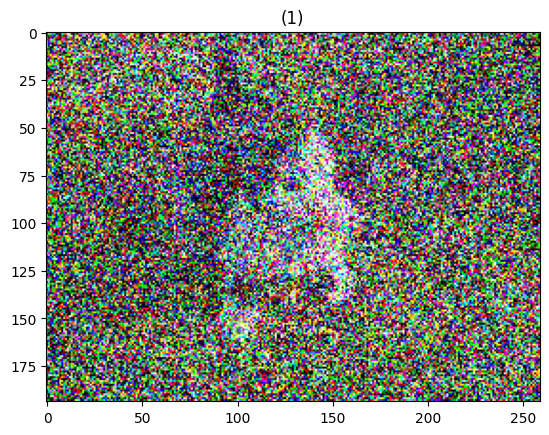

In [59]:
def style_transfer(content,style,r,L,Iirls,patch_sizes,subsampling_gaps, Ialg):
    # color transfer
    # gaussian pyramid
    # patch tree(optional)
    X= np.random.normal(0,50,np.shape(content))
    for l in range (L-1,0,-1):
        for s in range(0,len(patch_sizes)):
            style_patches =  extract_patches(style,patch_sizes[s],subsampling_gaps[s])
            nn_model = NearestNeighbors(n_neighbors=1).fit(style_patches)
            z=[]
            for k in range(0,Ialg):
                Xp=extract_patches(X,patch_sizes[s],subsampling_gaps[s])
                for Xpatch in Xp:
                   z.append(nn_model.kneighbors(Xpatch))


style=io.imread("imgs/starry.jpg")
print(np.shape(style))
X=io.imread("imgs/cat.jpg")
X= random_noise(X, mode="gaussian",mean=0,var=0.5)
style_patches =  extract_patches(style,(20,20,3),20)
z=[]
style_patches = style_patches.reshape(-1, 20 * 20 * 3)
# print(np.shape(Xp))
nn_model = NearestNeighbors(n_neighbors=1).fit(style_patches)

# for i in range(0,10):
print(X.shape)
Xp=extract_patches(X,(20,20,3),20)
# print(i , str (Xp.shape))
Xp = Xp.reshape(-1, 20 * 20 * 3)
for Xpatch in Xp:
    temp_arr = [Xpatch]
    index = nn_model.kneighbors(temp_arr)[1][0][0] 
    z.append(style_patches[index])
    # X = np.array(z) # should be replaced by the new xpatches generated from irls

show_images([X])

In [ ]:
()